In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as pyo
import seaborn as sns
from natsort import index_natsorted
from scipy.stats import norm
from __future__ import print_function
import ipywidgets as widgets
from ipywidgets import fixed, interact, interact_manual, interactive
%load_ext line_profiler
%matplotlib inline
pyo.init_notebook_mode(connected=True)

## Read in Plasmid predictions

In [3]:
df = pd.read_csv("/n/scratch3/users/a/ak586/microtrawler/3_analysis-resistance/all_rgiout_2022-06-21", sep="\t")
df = df.sort_values(
    by=["Accession_Number"],
    ascending=True,
    key=lambda x: np.argsort(index_natsorted(df["Accession_Number"])),
    ignore_index=True,
)
single_acc_df = df.drop_duplicates(subset=['Accession_Number'])
year_dict = single_acc_df[['Accession_Number','Year_Cultured']].set_index('Accession_Number').to_dict()['Year_Cultured']
df[["Species", "Subspecies"]] = df["Strain"].str.split("subsp.", 1, expand=True)
df = df.replace(np.nan, "Null", regex=True)
rgiintegron = pd.read_csv('/n/scratch3/users/a/ak586/microtrawler/3_analysis-resistance/rgi_subset_integronoverlap', sep='\t', names=df.columns.values)
rgiintegron["Species"] = rgiintegron["Strain"].str.split("subsp.", 1, expand=True)
rgiintegron["Subspecies"] = "Null"

In [4]:
contigdf = pd.concat([df['Accession_Number'], df['Contig'].str.split('_', expand=True)[0].str.split('|').str[-1]], axis=1).copy()
plasmidfinder_out = pd.read_csv("/n/scratch3/users/a/ak586/microtrawler/3_analysis-plasmid/merged-plasmidfinder", sep='\t')
plasmidfinder_out['CleanContig'] = plasmidfinder_out['Contig'].str.split(' ', expand=True)[0]
plasmidfinder_out['Year'] = plasmidfinder_out['AccNum'].map(year_dict)

# mob_out = pd.read_csv("/n/scratch3/users/a/ak586/microtrawler/3_analysis-plasmid/merged-mobout", sep='\t')
# mob_out[0] = mob_out['contig_id'].str.split(' ', expand=True)[0]
# mob_rgi = df.loc[contigdf[0].isin(mob_out[0])].copy()

ecoli_mlplasmid_out = pd.read_csv('/n/scratch3/users/a/ak586/microtrawler/3_analysis-plasmid/merged-Escherichia_coli-mlplasmidout', sep='\t')
ecoli_mlplasmid_out['Contig'] = ecoli_mlplasmid_out['Contig_name'].str.split(' ', expand=True)[0]
ecoli_mlplasmid_out['Year'] = ecoli_mlplasmid_out['AccNum'].map(year_dict)
ecoli_mlplasmids_rgi = contigdf.loc[contigdf['Accession_Number'].isin(ecoli_mlplasmid_out['AccNum'])]
ecoli_mlplasmids_rgi = ecoli_mlplasmids_rgi.loc[ecoli_mlplasmids_rgi[0].isin(ecoli_mlplasmid_out['Contig'])]
ecoli_mlplasmids_rgi = df.loc[ecoli_mlplasmids_rgi.index].copy()
ecoli_mlplasmids_rgi['CleanContig'] = ecoli_mlplasmids_rgi['Contig'].str.split('_', expand=True)[0]

kleb_mlplasmid_out = pd.read_csv('/n/scratch3/users/a/ak586/microtrawler/3_analysis-plasmid/merged-Klebsiella_pneumoniae-mlplasmidout', sep='\t')
kleb_mlplasmid_out['Contig'] = kleb_mlplasmid_out['Contig_name'].str.split(' ', expand=True)[0]
klebplasmids_df = contigdf.loc[contigdf['Accession_Number'].isin(kleb_mlplasmid_out['AccNum'])]
klebplasmids_df = klebplasmids_df.loc[klebplasmids_df[0].isin(kleb_mlplasmid_out['Contig'])]
klebplasmids_df = df.loc[klebplasmids_df.index].copy()

In [5]:
contig_mob = pd.read_csv("/n/scratch3/users/a/ak586/microtrawler/3_analysis-plasmid/merged-contigreport", sep='\t')
contig_mob[0] = contig_mob['contig_id'].str.split(' ', expand=True)[0]
contig_mob['sample'] = contig_mob['sample_id']+":"+contig_mob['primary_cluster_id']
contig_mob
# mob_rgi = df.loc[contigdf[0].isin(mob_out[0])].copy()

,AccNum,sample_id,molecule_type,primary_cluster_id,secondary_cluster_id,contig_id,size,gc,md5,circularity_status,...,orit_accession(s),predicted_mobility,mash_nearest_neighbor,mash_neighbor_distance,mash_neighbor_identification,repetitive_dna_id,repetitive_dna_type,filtering_reason,0,sample
0,NCTC10005,assembly,plasmid,AA424,AI484,UGJB01000001.1 Enterobacter cloacae strain NCT...,11122,51.348678,95f9a5cf43a0297cd4af316ffce2c6b8,not tested,...,-,-,CP001919,0.00433199,Enterobacter cloacae subsp. cloacae ATCC 13047,-,-,-,UGJB01000001.1,assembly:AA424
1,NCTC10005,assembly,plasmid,AE199,AN927,UGJB01000002.1 Enterobacter cloacae strain NCT...,87975,47.577153,3c597b494df83c0a2e5816808e53da33,not tested,...,-,-,NC_014108,0.00113443,Enterobacter cloacae subsp. cloacae ATCC 13047,-,-,-,UGJB01000002.1,assembly:AE199
2,NCTC10005,assembly,plasmid,AA424,AI484,UGJB01000003.1 Enterobacter cloacae strain NCT...,160937,52.185016,6ff757a7f4526299bce4d7d046d4cf76,not tested,...,-,-,CP001919,0.00433199,Enterobacter cloacae subsp. cloacae ATCC 13047,-,-,-,UGJB01000003.1,assembly:AA424
3,NCTC10005,assembly,plasmid,AA424,AI484,UGJB01000005.1 Enterobacter cloacae strain NCT...,5585,46.105640,4ec2cacd0397ff2cb84a772d2e70acda,not tested,...,-,-,CP001919,0.00433199,Enterobacter cloacae subsp. cloacae ATCC 13047,-,-,-,UGJB01000005.1,assembly:AA424
4,NCTC10006,assembly_10,plasmid,AH399,AR455,ENA|LR134131|LR134131.1 Klebsiella aerogenes s...,2105,38.194774,1153df154e83eefd927594fe09f76be2,not tested,...,-,-,LR134131,0.0,Klebsiella aerogenes,-,-,-,ENA|LR134131|LR134131.1,assembly_10:AH399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1512,NCTC9969,assembly,plasmid,AC621,AL885,UGES01000001.1 Escherichia coli strain NCTC996...,33921,43.176793,d99118e3dea68679e078a7c2acd2c605,not tested,...,-,-,CP023368,0.00580821,Escherichia coli,-,-,-,UGES01000001.1,assembly:AC621
1513,NCTC9969,assembly,plasmid,AA179,AH867,UGES01000002.1 Escherichia coli strain NCTC996...,15794,45.226035,afeb427af213d1813116992b0b238ef9,not tested,...,-,-,CP021198,0.0202797,Escherichia coli,-,-,-,UGES01000002.1,assembly:AA179
1514,NCTC9969,assembly,plasmid,AC621,AL885,UGES01000003.1 Escherichia coli strain NCTC996...,63132,43.825635,b588db7003855ddcd04b9e1c2ffe6ccb,not tested,...,-,-,CP023368,0.00580821,Escherichia coli,-,-,-,UGES01000003.1,assembly:AC621
1515,NCTC9969,assembly,plasmid,AA179,AH867,UGES01000007.1 Escherichia coli strain NCTC996...,161332,49.476235,78919d30362f71853cf0d5550aff9bf4,not tested,...,HG796403,-,CP021198,0.0202797,Escherichia coli,-,-,-,UGES01000007.1,assembly:AA179


In [6]:
mobtyper_mob = pd.read_csv("/n/scratch3/users/a/ak586/microtrawler/3_analysis-plasmid/merged-mobtyper", sep='\t')
mobtyper_mob['sample'] = mobtyper_mob['sample_id']
mobtyper_mob

,AccNum,sample_id,num_contigs,size,gc,md5,rep_type(s),rep_type_accession(s),relaxase_type(s),relaxase_type_accession(s),...,primary_cluster_id,secondary_cluster_id,predicted_host_range_overall_rank,predicted_host_range_overall_name,observed_host_range_ncbi_rank,observed_host_range_ncbi_name,reported_host_range_lit_rank,reported_host_range_lit_name,associated_pmid(s),sample
0,NCTC10005,assembly:AA424,3,177644,51.941523,f0e8e64b80be3f25839e02755e530f08,"IncFIB,IncFII,rep_cluster_2358","CP039454_00078,CP019890_00139,CP000974_00005","MOBF,MOBP","NC_014107_00160,NC_021819_00066",...,AA424,AI484,phylum,Proteobacteria,order,Enterobacterales,phylum,Proteobacteria,24096417,assembly:AA424
1,NCTC10005,assembly:AE199,1,87975,47.577153,3c597b494df83c0a2e5816808e53da33,rep_cluster_867,002347__CP001920_00047,MOBF,NC_014108_00108,...,AE199,AN927,genus,Enterobacter,genus,Enterobacter,-,-,-,assembly:AE199
2,NCTC10006,assembly_10:AH399,1,2105,38.194774,1153df154e83eefd927594fe09f76be2,-,-,-,-,...,AH399,AR455,genus,Klebsiella,genus,Klebsiella,-,-,-,assembly_10:AH399
3,NCTC10006,assembly_12:AH177,1,6249,43.815010,add2ec8852dcb0977dd496ce6156fb94,-,-,-,-,...,AH177,AR233,genus,Klebsiella,genus,Klebsiella,-,-,-,assembly_12:AH177
4,NCTC10006,assembly_7:AG790,1,7647,36.811822,fb84cf4d2241d3964f865d74f25455f6,-,-,-,-,...,AG790,AQ846,genus,Klebsiella,genus,Klebsiella,-,-,-,assembly_7:AG790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1096,NCTC9963,assembly:AA336,1,130556,49.255492,39ed2ddfec96f53d4d3b702e8edaaee9,"IncFIA,IncFII","CP022610_00144,LS992172_00069","MOBF,MOBF","CP029214_00066,CP008715_00128",...,AA336,-,family,Enterobacteriaceae,family,Enterobacteriaceae,-,-,-,assembly:AA336
1097,NCTC9965,assembly:AA304,2,70980,46.129896,3f083418c312e47b5abda402ad2f2088,"IncFIA,IncFIA,IncFIB,IncFIB","AF250878,000136__AP014877_00014,000095__NZ_CP0...",-,-,...,AA304,-,order,Enterobacterales,order,Enterobacterales,order,Enterobacterales,11254626; 19482926; 15781495; 20851899; 16257053,assembly:AA304
1098,NCTC9969,assembly:AC621,2,97053,43.598858,ce97d8e29445b3e8d8c3427a31957e3a,-,-,-,-,...,AC621,AL885,genus,Escherichia,genus,Escherichia,-,-,-,assembly:AC621
1099,NCTC9969,assembly:AA179,2,177126,49.097253,ce7d68848253ad18e5462e515c569a1b,"IncFIB,IncFIC,rep_cluster_2244","000096__NC_019117_00097,AP001918,CP033091_00053","MOBF,MOBF","MF535908_00027,NC_011964_00125",...,AA179,AH867,genus,Escherichia,genus,Escherichia,-,-,-,assembly:AA179


In [7]:
merged_mob = mobtyper_mob.merge(contig_mob, on='sample').drop_duplicates(subset=['AccNum_x', 'sample_id_x']).reset_index()
merged_mob['Year'] = merged_mob['AccNum_x'].map(year_dict)
merged_mob

,index,AccNum_x,sample_id_x,num_contigs,size_x,gc_x,md5_x,rep_type(s)_x,rep_type_accession(s)_x,relaxase_type(s)_x,...,orit_accession(s)_y,predicted_mobility_y,mash_nearest_neighbor_y,mash_neighbor_distance_y,mash_neighbor_identification_y,repetitive_dna_id,repetitive_dna_type,filtering_reason,0,Year
0,0,NCTC10005,assembly:AA424,3,177644,51.941523,f0e8e64b80be3f25839e02755e530f08,"IncFIB,IncFII,rep_cluster_2358","CP039454_00078,CP019890_00139,CP000974_00005","MOBF,MOBP",...,-,-,CP001919,0.00433199,Enterobacter cloacae subsp. cloacae ATCC 13047,-,-,-,UGJB01000001.1,1958
1,3,NCTC10005,assembly:AE199,1,87975,47.577153,3c597b494df83c0a2e5816808e53da33,rep_cluster_867,002347__CP001920_00047,MOBF,...,-,-,NC_014108,0.00113443,Enterobacter cloacae subsp. cloacae ATCC 13047,-,-,-,UGJB01000002.1,1958
2,4,NCTC10006,assembly_10:AH399,1,2105,38.194774,1153df154e83eefd927594fe09f76be2,-,-,-,...,-,-,LR134131,0.0,Klebsiella aerogenes,-,-,-,ENA|LR134131|LR134131.1,1958
3,5,NCTC10006,assembly_12:AH177,1,6249,43.815010,add2ec8852dcb0977dd496ce6156fb94,-,-,-,...,-,-,LR134133,0.0,Klebsiella aerogenes,-,-,-,ENA|LR134133|LR134133.1,1958
4,6,NCTC10006,assembly_7:AG790,1,7647,36.811822,fb84cf4d2241d3964f865d74f25455f6,-,-,-,...,-,-,LR134128,0.0,Klebsiella aerogenes,-,-,-,ENA|LR134128|LR134128.1,1958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1096,9451,NCTC9778,assembly:AA976,1,5982,47.225008,3387e95c10cb7e207236277926a56d0c,-,-,MOBQ,...,-,-,DQ995354,0.00997914,Escherichia coli,-,-,-,UGAI01000001.1,1955
1097,9452,NCTC9793,assembly_3:AF144,1,24306,49.831317,28b41853892beb1dd038d493a96ead26,-,-,-,...,-,-,LR134278,0.0,Klebsiella aerogenes,-,-,-,ENA|LR134278|LR134278.1,1946
1098,9453,NCTC9853,assembly:novel_e753edade1796dba647b5c54d4f95ba5,1,9569,51.510085,e753edade1796dba647b5c54d4f95ba5,IncFIB,000107__CP014778_00094,MOBP,...,-,-,CP039329,0.0903831,Citrobacter portucalensis,-,-,-,MWLY01000035.1,1956
1099,9454,NCTC9963,assembly:AA319,1,139176,48.542852,bab795010db19989d16899a6f0539ada,"IncFIB,IncFIC,rep_cluster_2244","000095__NZ_CP014273_00094,AP001918,CP033091_00053","MOBF,MOBF",...,-,-,CP010158,0.0157245,Escherichia coli,-,-,-,UGDS01000002.1,1976


In [8]:
mob_rgi = merged_mob.loc[merged_mob[0].isin(contigdf[0])].copy()
mob_rgi

,index,AccNum_x,sample_id_x,num_contigs,size_x,gc_x,md5_x,rep_type(s)_x,rep_type_accession(s)_x,relaxase_type(s)_x,...,orit_accession(s)_y,predicted_mobility_y,mash_nearest_neighbor_y,mash_neighbor_distance_y,mash_neighbor_identification_y,repetitive_dna_id,repetitive_dna_type,filtering_reason,0,Year
7,9,NCTC10035,assembly:AC333,1,4439,30.051813,3c6e2037827c6b8c13f965225aa18b8a,rep_cluster_1118,000379__NC_013452_00003,MOBV,...,-,-,NC_005008,0.00028831,Staphylococcus epidermidis ATCC 12228,-,-,-,UHCJ01000001.1,1959
8,18,NCTC10442,assembly:AC333,1,5395,29.990732,0c6b51e35bcf93d2f4d7b4354df1b784,rep_cluster_1118,000379__NC_013452_00003,MOBV,...,-,-,NC_005008,0.00028831,Staphylococcus epidermidis ATCC 12228,-,-,-,UHCJ01000001.1,1960
9,27,NCTC10443,assembly:AC333,1,3185,29.262166,b5db81ce1bcbde98e65995bbca5ae1c1,rep_cluster_1118,000379__NC_013452_00003,-,...,-,-,NC_005008,0.00028831,Staphylococcus epidermidis ATCC 12228,-,-,-,UHCJ01000001.1,1964
10,36,NCTC10654,assembly:AC333,1,4663,30.280935,b9104726b0978b2c3c5164d057f3f2d4,rep_cluster_1118,000379__NC_013452_00003,MOBV,...,-,-,NC_005008,0.00028831,Staphylococcus epidermidis ATCC 12228,-,-,-,UHCJ01000001.1,1954
11,45,NCTC10724,assembly:AC333,1,7797,29.870463,21db7d5e537c9559bf70b2b87fcc0b30,rep_cluster_1118,000379__NC_013452_00003,"MOBV,MOBV,MOBV",...,-,-,NC_005008,0.00028831,Staphylococcus epidermidis ATCC 12228,-,-,-,UHCJ01000001.1,1970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1036,9288,NCTC9175,assembly:AA405,1,311749,47.910980,e698c322f5aa989ec28ff9f90ed19d8b,"IncFIB,IncHI1B","CP024497_00001,JN420336",MOBH,...,-,-,CP032223,0.0162193,Klebsiella pneumoniae,-,-,-,CABDVV010000003.1,1952
1037,9290,NCTC9130,assembly:AC296,1,51233,61.192981,6b9d944c6c53d0cf4ac20bc6cac9089b,IncP,000175__JQ004408_00022,MOBP,...,KX712121,-,CP028340,0.00319852,Thauera aromatica K172,-,-,-,UGNF01000002.1,1952
1040,9293,NCTC9137,assembly:AD768,1,50631,57.776856,f8e67ebd76df60fffc529a58c2652530,IncW,000213__AM901564_00031,MOBF,...,CP011434,-,AP018350,0.00343111,Enterobacter hormaechei,-,-,-,CABDVY010000001.1,1952
1041,9295,NCTC9143,assembly:AD768,1,14014,56.978736,a95b795ed568c2a7f3cfdadd706f91ac,IncW,000213__AM901564_00031,-,...,CP011434,-,AP018350,0.00343111,Enterobacter hormaechei,-,-,-,CABDVY010000001.1,1952


In [9]:
mob_rgi = merged_mob.loc[merged_mob[0].isin(ecoli_mlplasmid_out['Contig'])].copy()
mob_rgi

,index,AccNum_x,sample_id_x,num_contigs,size_x,gc_x,md5_x,rep_type(s)_x,rep_type_accession(s)_x,relaxase_type(s)_x,...,orit_accession(s)_y,predicted_mobility_y,mash_nearest_neighbor_y,mash_neighbor_distance_y,mash_neighbor_identification_y,repetitive_dna_id,repetitive_dna_type,filtering_reason,0,Year
53,867,NCTC10089,assembly:AB269,1,128351,48.499038,829fe90f8e1239f653d510850422b762,"IncFIA,IncFIB","000136__AP014877_00014,000096__NC_019117_00097",MOBF,...,CP000430,-,FM180569,0.037311,Escherichia coli O127:H6 str. E2348/69,-,-,-,CABEEY010000005.1,1960
54,878,NCTC8009,assembly:AB269,1,129043,48.400146,aff16bfb46f79cdabad94d2ec66ac78f,"IncFIA,IncFIB","CP022610_00144,000101__NZ_CP012345_00042",MOBF,...,CP000430,-,FM180569,0.037311,Escherichia coli O127:H6 str. E2348/69,-,-,-,CABEEY010000005.1,1949
55,889,NCTC8333,assembly:AB269,2,184832,49.144629,a57f90f7ffb0eb58a90eec7c17a93b59,"IncFIA,IncFIA,IncFIB","000136__AP014877_00014,CP022610_00144,000101__...","MOBF,MOBF,MOBF,MOBF,MOBF",...,CP000430,-,FM180569,0.037311,Escherichia coli O127:H6 str. E2348/69,-,-,-,CABEEY010000005.1,1950
56,900,NCTC8603,assembly:AB269,1,71227,46.770185,ddb4cb4b636659939dfc4ee6571ff235,"IncFIA,IncFIB","CP022610_00144,000101__NZ_CP012345_00042",-,...,CP000430,-,FM180569,0.037311,Escherichia coli O127:H6 str. E2348/69,-,-,-,CABEEY010000005.1,1947
57,911,NCTC8621,assembly:AB269,1,104095,47.536385,5f8dd0a49c6ca62c4607460da27b3518,"IncFIA,IncFIB","CP022610_00144,000101__NZ_CP012345_00042","MOBF,MOBF",...,CP000430,-,FM180569,0.037311,Escherichia coli O127:H6 str. E2348/69,-,-,-,CABEEY010000005.1,1949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1018,9159,NCTC9101,assembly:AA670,1,7677,45.538622,54b3bf152f1c4de7a6373dbd7a0487d8,rep_cluster_2350,CP041342_00001,-,...,NZ_CP011138,-,CP019695,0.0204123,Shigella sonnei,-,-,-,UGDK01000004.1,1952
1022,9163,NCTC9120,assembly:AA158,1,5711,42.934687,40593a79f2f2ecc333d4d2cde09e83d6,rep_cluster_2350,CP035723_00002,MOBP,...,MF083142,-,NC_019982,0.00989629,Escherichia coli,-,-,-,UGFS01000003.1,1952
1093,9448,NCTC9707,assembly:novel_2a6c537881c90541c525a9a2709d5ac8,1,4486,47.302720,2a6c537881c90541c525a9a2709d5ac8,Col156,CP001126_00001,-,...,-,-,CP032517,0.0671564,Escherichia coli,-,-,-,UGGC01000004.1,1955
1095,9450,NCTC9777,assembly:AC411,1,8958,48.961822,2f1b2b51b9f04901a6148da778b93127,Col156,CP001126_00001,MOBQ,...,-,-,LT985301,0.0313762,Escherichia coli,-,-,-,UASC01000011.1,1955


In [10]:
ecoli_mlplasmid_out.loc[ecoli_mlplasmid_out['Contig'].isin(merged_mob[0])]

,AccNum,Prob_Chrom,Prob_Plasmid,Prediction,Contig_name,Contig_len,Contig,Year
1,NCTC10089,0.173210,0.826790,Plasmid,CABEEY010000005.1 Escherichia coli strain NCTC...,128351,CABEEY010000005.1,1960
2,NCTC10090,0.026375,0.973625,Plasmid,UGFA01000003.1 Escherichia coli strain NCTC100...,5815,UGFA01000003.1,1960
3,NCTC10279,0.052393,0.947607,Plasmid,UASG01000001.1 Escherichia coli strain NCTC102...,6250,UASG01000001.1,1962
4,NCTC10279,0.256110,0.743890,Plasmid,UASG01000004.1 Escherichia coli strain NCTC102...,4528,UASG01000004.1,1962
6,NCTC10429,0.239130,0.760870,Plasmid,UGEX01000005.1 Escherichia coli strain NCTC104...,108471,UGEX01000005.1,1965
...,...,...,...,...,...,...,...,...
188,NCTC9101,0.149796,0.850204,Plasmid,UGDK01000004.1 Escherichia coli strain NCTC910...,7677,UGDK01000004.1,1952
199,NCTC9120,0.183105,0.816895,Plasmid,UGFS01000003.1 Escherichia coli strain NCTC912...,5711,UGFS01000003.1,1952
212,NCTC9707,0.009951,0.990049,Plasmid,UGGC01000004.1 Escherichia coli strain NCTC970...,4486,UGGC01000004.1,1955
222,NCTC9777,0.008379,0.991621,Plasmid,UASC01000011.1 Escherichia coli strain NCTC977...,8958,UASC01000011.1,1955


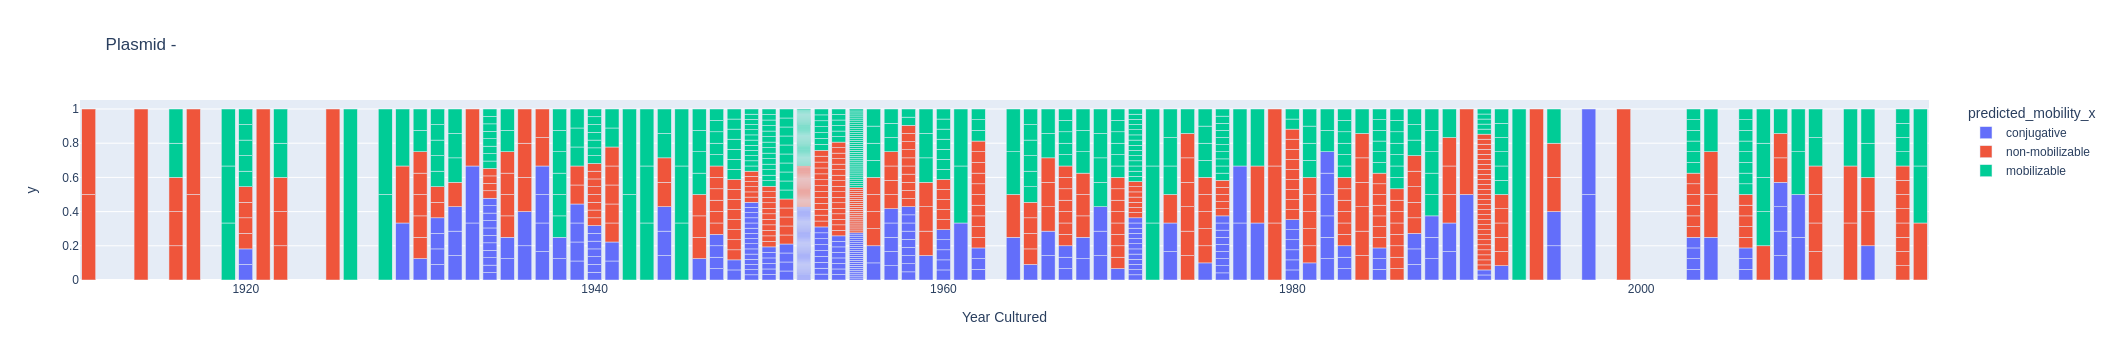

In [11]:
px.bar(
    merged_mob,
    x="Year",
    y=merged_mob['Year'].map((1/merged_mob['Year'].value_counts()).to_dict()),
    labels={"Year": "Year Cultured", },
    title="Plasmid - ",
    # hover_data=["Accession_Number", "Resistance Mechanism", "Best_Hit_ARO", "Drug Class", "AMR Gene Family", 'Contig', 'Strain'],
    # color='Best_Hit_ARO',
    color='predicted_mobility_x'
)

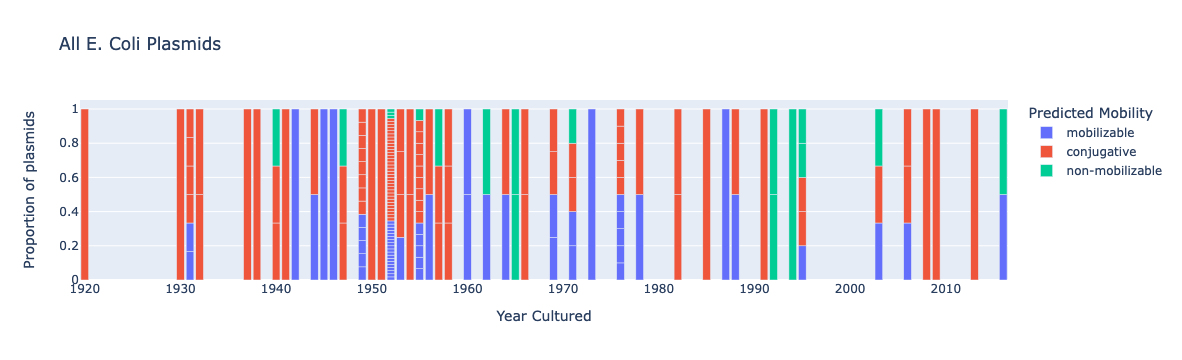

In [12]:
mob_rgi = merged_mob.loc[merged_mob[0].isin(ecoli_mlplasmid_out['Contig'])].copy()
px.bar(
    mob_rgi,
    x="Year",
    y=mob_rgi['Year'].map((1/mob_rgi['Year'].value_counts()).to_dict()),
    labels={"Year": "Year Cultured", 'predicted_mobility_x': "Predicted Mobility", 'y': 'Proportion of plasmids'},
    title="All E. Coli Plasmids",
    # hover_data=["Accession_Number", "Resistance Mechanism", "Best_Hit_ARO", "Drug Class", "AMR Gene Family", 'Contig', 'Strain'],
    # color='Best_Hit_ARO',
    color='predicted_mobility_x'
)

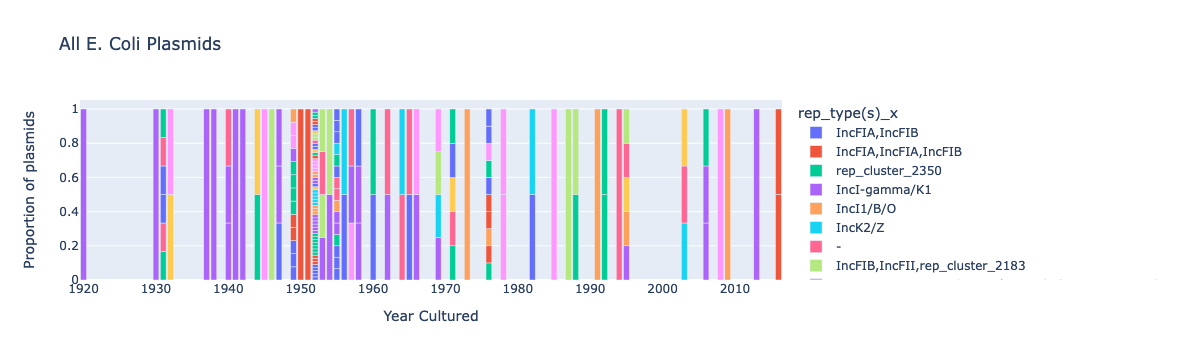

In [13]:
px.bar(
    mob_rgi,
    x="Year",
    y=mob_rgi['Year'].map((1/mob_rgi['Year'].value_counts()).to_dict()),
    labels={"Year": "Year Cultured", 'predicted_mobility_x': "Predicted Mobility", 'y': 'Proportion of plasmids'},
    title="All E. Coli Plasmids",
    # hover_data=["Accession_Number", "Resistance Mechanism", "Best_Hit_ARO", "Drug Class", "AMR Gene Family", 'Contig', 'Strain'],
    # color='Best_Hit_ARO',
    color='rep_type(s)_x'
)

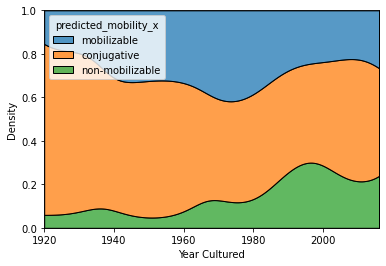

In [12]:
fig = sns.kdeplot(data=mob_rgi, x="Year", hue="predicted_mobility_x", multiple="fill", cut=0, bw_adjust=0.9)
plt.xlabel('Year Cultured')
sns.move_legend(fig, loc='upper left')
# plt.savefig('./all-blactamases.png', dpi=200)

In [15]:
mob_rgi
# ecoli_mlplasmids_rgi['Contig']

,index,AccNum_x,sample_id_x,num_contigs,size_x,gc_x,md5_x,rep_type(s)_x,rep_type_accession(s)_x,relaxase_type(s)_x,...,predicted_mobility_y,mash_nearest_neighbor_y,mash_neighbor_distance_y,mash_neighbor_identification_y,repetitive_dna_id,repetitive_dna_type,filtering_reason,0,Year,contig
366,6739,NCTC10650,assembly:AA551,1,62639,53.236801,d12855b0713a62c4ab46ba1efb1b7521,IncN,000153__NC_019087_00001,MOBF,...,-,HE613857,0.00594242,Escherichia coli,-,-,-,UART01000002.1,1969,UART01000002.1
367,6742,NCTC12116,assembly:AA551,1,36272,50.589987,5d01703c97e09a749e61f9435981b1e7,IncN,000155__CP018649,MOBF,...,-,HE613857,0.00594242,Escherichia coli,-,-,-,UART01000002.1,1987,UART01000002.1
368,6745,NCTC13352,assembly:AA551,1,51363,51.745420,76e7c4d7c883433401b50f790559339a,IncN,000153__NC_019087_00001,MOBF,...,-,HE613857,0.00594242,Escherichia coli,-,-,-,UART01000002.1,1988,UART01000002.1
503,7643,NCTC10957,assembly:AA738,1,220668,45.501840,b22d6d478e655c244cdd8cc586193a7f,"IncHI2A,rep_cluster_1088","BX664015,000340__KU353730",MOBH,...,-,MN232195,0.00597612,Escherichia coli,-,-,-,UGFJ01000002.1,1971,UGFJ01000002.1
504,7648,NCTC13462,assembly:AA738,1,239622,46.502408,14324db39984738e5634ebc458c435b1,"IncHI2A,rep_cluster_1088","BX664015,000340__KU353730",MOBH,...,-,MN232195,0.00597612,Escherichia coli,-,-,-,UGFJ01000002.1,2006,UGFJ01000002.1
505,7653,NCTC13846,assembly:AA738,2,314654,45.694636,a465d5066ffecfa02bcaf810339975fd,"IncHI2A,rep_cluster_1088,IncI2","BX664015,000340__KU353730,JN983044","MOBH,MOBP",...,-,MN232195,0.00597612,Escherichia coli,-,-,-,UGFJ01000002.1,2013,UGFJ01000002.1
506,7658,NCTC9068,assembly:AA738,1,189530,44.374505,abda961c8ac1ba5bbc25c362fca6b200,"IncHI2A,rep_cluster_1088","BX664015,000340__KU353730",MOBH,...,-,MN232195,0.00597612,Escherichia coli,-,-,-,UGFJ01000002.1,1952,UGFJ01000002.1
509,7667,NCTC10960,assembly:AA315,1,98022,53.351288,616262f73d96a47462963cc02c22bf04,"IncFIA,IncFIC","000136__AP014877_00014,CP014493_00001",MOBF,...,-,MK092064,0.00804257,Escherichia coli,-,-,-,UGFL01000004.1,1971,UGFL01000004.1
510,7669,NCTC8620,assembly:AA315,1,61786,52.040915,bdb596f81caf9026df69cf236911895e,IncFIA,000136__AP014877_00014,"MOBF,MOBF",...,-,MK092064,0.00804257,Escherichia coli,-,-,-,UGFL01000004.1,1949,UGFL01000004.1
566,7876,NCTC11472,assembly:AA334,2,238745,52.069363,47b061d759f83896bab496bfcec70f58,"IncFIA,IncFIB,IncFIA,IncFIC","CP012501_00008,000095__NZ_CP014273_00094,00013...","MOBF,MOBF,MOBP",...,-,NC_008460,0.017359,Escherichia coli,-,-,-,UGAG01000003.1,1982,UGAG01000003.1


/home/ak586/.conda/envs/RESIST/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.



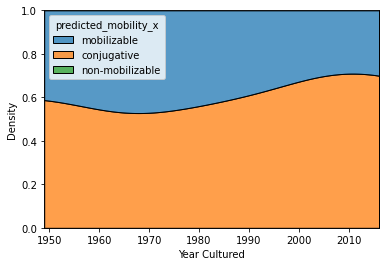

In [14]:
merged_mob['contig'] = merged_mob['contig_id'].str.split(' ', expand=True)[0]
ecoli_mlplasmids_rgi['contig'] = ecoli_mlplasmids_rgi['Contig'].str.split('_', expand=True)[0]
mob_rgi = merged_mob.loc[merged_mob['contig'].isin(ecoli_mlplasmids_rgi['contig'])].copy()
fig = sns.kdeplot(data=mob_rgi, x="Year", hue="predicted_mobility_x", multiple="fill", cut=0, bw_adjust=0.9)
plt.xlabel('Year Cultured')
sns.move_legend(fig, loc='upper left')

In [16]:
# mob_out.loc[mob_out['contig_id'].isin(ecoli_mlplasmid_out['Contig_name'])]['predicted_mobility'].value_counts()

In [22]:
for i in mob_rgi:
    print(i)

index
AccNum_x
sample_id_x
num_contigs
size_x
gc_x
md5_x
rep_type(s)_x
rep_type_accession(s)_x
relaxase_type(s)_x
relaxase_type_accession(s)_x
mpf_type_x
mpf_type_accession(s)_x
orit_type(s)_x
orit_accession(s)_x
predicted_mobility_x
mash_nearest_neighbor_x
mash_neighbor_distance_x
mash_neighbor_identification_x
primary_cluster_id_x
secondary_cluster_id_x
predicted_host_range_overall_rank
predicted_host_range_overall_name
observed_host_range_ncbi_rank
observed_host_range_ncbi_name
reported_host_range_lit_rank
reported_host_range_lit_name
associated_pmid(s)
sample
AccNum_y
sample_id_y
molecule_type
primary_cluster_id_y
secondary_cluster_id_y
contig_id
size_y
gc_y
md5_y
circularity_status
rep_type(s)_y
rep_type_accession(s)_y
relaxase_type(s)_y
relaxase_type_accession(s)_y
mpf_type_y
mpf_type_accession(s)_y
orit_type(s)_y
orit_accession(s)_y
predicted_mobility_y
mash_nearest_neighbor_y
mash_neighbor_distance_y
mash_neighbor_identification_y
repetitive_dna_id
repetitive_dna_type
filtering

In [25]:
px.bar(
    mob_rgi.drop_duplicates(subset="contig_id"),
    x="Year",
    y=mob_rgi.drop_duplicates(subset="contig_id")['Year'].map((1/mob_rgi.drop_duplicates(subset="contig_id")['Year'].value_counts()).to_dict()),
    labels={"Year_Cultured": "Year Cultured"},
    title="Plasmids",
    # hover_data=["Accession_Number", "Resistance Mechanism", "Best_Hit_ARO", "Drug Class", "AMR Gene Family", 'Contig', 'Strain'],
    color='Best_Hit_ARO',
)

ValueError: Value of 'color' is not the name of a column in 'data_frame'. Expected one of ['index', 'AccNum_x', 'sample_id_x', 'num_contigs', 'size_x', 'gc_x', 'md5_x', 'rep_type(s)_x', 'rep_type_accession(s)_x', 'relaxase_type(s)_x', 'relaxase_type_accession(s)_x', 'mpf_type_x', 'mpf_type_accession(s)_x', 'orit_type(s)_x', 'orit_accession(s)_x', 'predicted_mobility_x', 'mash_nearest_neighbor_x', 'mash_neighbor_distance_x', 'mash_neighbor_identification_x', 'primary_cluster_id_x', 'secondary_cluster_id_x', 'predicted_host_range_overall_rank', 'predicted_host_range_overall_name', 'observed_host_range_ncbi_rank', 'observed_host_range_ncbi_name', 'reported_host_range_lit_rank', 'reported_host_range_lit_name', 'associated_pmid(s)', 'sample', 'AccNum_y', 'sample_id_y', 'molecule_type', 'primary_cluster_id_y', 'secondary_cluster_id_y', 'contig_id', 'size_y', 'gc_y', 'md5_y', 'circularity_status', 'rep_type(s)_y', 'rep_type_accession(s)_y', 'relaxase_type(s)_y', 'relaxase_type_accession(s)_y', 'mpf_type_y', 'mpf_type_accession(s)_y', 'orit_type(s)_y', 'orit_accession(s)_y', 'predicted_mobility_y', 'mash_nearest_neighbor_y', 'mash_neighbor_distance_y', 'mash_neighbor_identification_y', 'repetitive_dna_id', 'repetitive_dna_type', 'filtering_reason', 0, 'Year', 'contig'] but received: Best_Hit_ARO

In [ ]:
x = plasmidfinder_out[plasmidfinder_out['CleanContig'].isin(ecoli_mlplasmid_out['Contig'])].drop_duplicates(subset='Contig')
px.bar(
    x,
    x="Year",
    y=x['Year'].map((1/x['Year'].value_counts()).to_dict()),
    labels={"Year": "Year Cultured"},
    title="Plasmids",
    # hover_data=["Accession_Number", "Resistance Mechanism", "Best_Hit_ARO", "Drug Class", "AMR Gene Family", 'Contig', 'Strain'],
    color='PlasmidGroup',
)

In [ ]:
# plasmidfinder_out[plasmidfinder_out['CleanContig'].isin(ecoli_mlplasmid_out['Contig'])].sort_values('Year').drop_duplicates(subset='AccNum')
x = plasmidfinder_out[plasmidfinder_out['CleanContig'].isin(ecoli_mlplasmids_rgi['CleanContig'])]
px.bar(
    x,
    x="Year",
    y=x['Year'].map((1/x['Year'].value_counts()).to_dict()),
    labels={"Year": "Year Cultured"},
    title="Plasmids",
    # hover_data=["Accession_Number", "Resistance Mechanism", "Best_Hit_ARO", "Drug Class", "AMR Gene Family", 'Contig', 'Strain'],
    color='PlasmidGroup',
)

In [ ]:
plasmidfinder_out[plasmidfinder_out['CleanContig'].isin(ecoli_mlplasmids_rgi['CleanContig'])]

In [ ]:
plasmidfinder_out.loc[plasmidfinder_out['CleanContig'] == 'UGAH01000001.1']

In [ ]:
plasmidfinder_out.loc[plasmidfinder_out['CleanContig'] == 'UGGA01000002.1']

In [ ]:
plasmidfinder_out.loc[plasmidfinder_out['CleanContig'] == 'UFZP01000001.1']

In [ ]:
plasmidfinder_out.loc[plasmidfinder_out['CleanContig'] == 'UGGK01000003.1']

In [ ]:
def generate_fracs(dataframe, value, column, verbose=False):
    num_yearcultured_allstrains_dict = (
        dataframe.drop_duplicates(subset=["Accession_Number"])["Year_Cultured"]
        .value_counts()
        .to_dict()
    )
    num_yearcultured_valposstrains_dict = (
        dataframe.loc[dataframe[column].str.contains(value, na=False, regex=True)]
        .drop_duplicates(subset=["Accession_Number"])["Year_Cultured"]
        .value_counts()
        .to_dict()
    )
    fractional_dictionary = {}
    for years in num_yearcultured_allstrains_dict:
        if num_yearcultured_allstrains_dict[years] == 0:
            continue
        if years in num_yearcultured_valposstrains_dict:
            val = [num_yearcultured_valposstrains_dict[years], num_yearcultured_allstrains_dict[years]]
            # fraction = (
            #     num_yearcultured_valposstrains_dict[years]
            #     / num_yearcultured_allstrains_dict[years]
            # )
        else:
            val = [0, num_yearcultured_allstrains_dict[years]]
        fractional_dictionary[years] = val

    yeardf = (
        pd.DataFrame.from_dict(fractional_dictionary, orient="index", columns=["num_pos", "all"])
        .reset_index()
        .rename(columns={"index": "year"})
        .sort_values(by="year")
        .reset_index(drop=True)
    )
    yeardf['frac'] = yeardf['num_pos']/yeardf['all']

    return yeardf

In [ ]:
def plot_frac(
    df,
    ex,
    verbose=True,
    smooth=5,
    col="Drug Class",
    value="phenotype",
    y2="Count of bugs analyzed"
):

    frac_df = generate_fracs(df, ex, col, verbose)
    # print(frac_df)

    # histogram of fraction of strains w/ RGI hits for drug class
    plt.figure(figsize=(14, 8))
    chart = sns.barplot(data=frac_df, x="year", y="frac", color="salmon", saturation=0.5)
    chart.bar_label(chart.containers[0])
    # plt.axvline(pd.Index(frac_df["year"]).get_loc(year, method="nearest"))
    plt.ylabel("Fraction of bugs with phenotype")
    plt.xlabel("Year")
    plt.xticks(rotation=45)
    plt.show()
    
    d = {"Year": [], "frac": []}
    for years in range(frac_df["year"].min(), frac_df["year"].max()):
        upb = smooth + years
        downb = years - smooth
        g = frac_df.loc[(frac_df["year"] <= upb) & (downb <= frac_df["year"])]
        d["Year"].append(years)
        d["frac"].append(g["frac"].mean())
    
    xdf = pd.DataFrame(data=d)
    # print(xdf)
    fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
    lp = sns.lineplot(
        data=xdf, x="Year", y="frac", markers=True, ax=axes[0]
    )
    lp.set(ylim=(0, 1))
    dp = sns.scatterplot(
        data=xdf, x="Year", y="frac", legend=False, ax=axes[0]
    )
    axes[0].set(ylabel='{}'.format(value))
    # dp.axvline(year, color="red")
    
    histogram = sns.histplot(data=df.drop_duplicates(subset=["Accession_Number"]), x='Year_Cultured', ax=axes[1])
    axes[1].set(ylabel='{}'.format(y2), xlabel="Year Cultured")
    return fig

In [ ]:
plot = plot_frac(df.loc[df['Strain'].str.contains("Escherichia coli")],
          '|'.join(list(ecoli_mlplasmid_out['AccNum'].drop_duplicates())),
          verbose=False,
          col='Accession_Number',
          smooth=7,
          value='Fraction of E. Coli with ≥ 1 plasmid',
          y2='Count of all E. Coli present'
)
plot.savefig('./coliplasmid-occ.png', dpi=200)

In [ ]:
plot = plot_frac(df.loc[df['Strain'].str.contains("Escherichia coli") & df['Accession_Number'].str.contains('|'.join(list(ecoli_mlplasmid_out['AccNum'].drop_duplicates())))],
          '|'.join(list(ecoli_mlplasmids_rgi['Accession_Number'].drop_duplicates())),
          verbose=False,
          col='Accession_Number',
          smooth=5,
          value='Fraction of plasmids carrying ≥ 1 AbR gene',
          y2='Count of E. Coli with plasmids'
)
plot.savefig('./coliplasmid-abr.png', dpi=200)

In [ ]:
ecoli_mlplasmid_out['AccNum'].unique().shape

In [ ]:
plasmidfinder_out = pd.read_csv("/n/scratch3/users/a/ak586/microtrawler/3_analysis-plasmid/merged-plasmidfinder", sep='\t')
# plasmidfinder_out
plasmidfinder_out.loc[plasmidfinder_out['Contig'].str.split(' ', expand=True)[0].isin(ecoli_mlplasmid_out['Contig'])]['Contig'].value_counts()

In [ ]:
plasmidfinder_out.loc[plasmidfinder_out['AccNum'] == "NCTC9776"]

In [ ]:
ecoli_mlplasmids_rgi

In [ ]:
plasmidfinder_out.loc[plasmidfinder_out['Contig'].str.split(' ', expand=True)[0].isin(ecoli_mlplasmid_out['Contig'])]['AccNum'].unique().shape

In [ ]:
ecoli_mlplasmids_rgi['Contig'].str.split('_', expand=True)[0]

In [ ]:
ecoli_mlplasmids_rgi['Accession_Number'].unique()

In [ ]:
plasmidfinder_out['Contig'].str.split(' ', expand=True)[0]

In [ ]:
plasmidfinder_out.loc[plasmidfinder_out['Contig'].str.split(' ', expand=True)[0].isin(ecoli_mlplasmids_rgi['Contig'].str.split('_', expand=True)[0])]['AccNum'].unique()

In [ ]:
plasmidfinder_out.loc[plasmidfinder_out['AccNum'].str.contains('|'.join(list(ecoli_mlplasmid_out['AccNum'])))]

In [ ]:
df.loc[df['Strain'].str.contains("Escherichia coli") & df['Accession_Number'].str.contains('|'.join(list(ecoli_mlplasmid_out['AccNum'].drop_duplicates())))]

In [ ]:
df.loc[df['Strain'].str.contains("Escherichia coli")]

In [ ]:
# year_dict
ecoliplasmidfinder_df = plasmidfinder_out.loc[plasmidfinder_out['AccNum'].str.contains('|'.join(list(ecoli_mlplasmid_out['AccNum'])))].copy()
ecoliplasmidfinder_df['Year_Cultured'] = ecoliplasmidfinder_df['AccNum'].map(year_dict)
ecoliplasmidfinder_df['PlasmidGroup'].value_counts()

In [ ]:
ecoliplasmidfinder_df.drop_duplicates(subset="Contig")

In [ ]:
ecoliplasmidfinder_df.drop_duplicates(subset="Contig")

In [ ]:
ecoliplasmidfinder_df.loc[ecoliplasmidfinder_df['Contig'].isin(ecoli_mlplasmid_out['Contig_name'])]

In [ ]:
px.bar(
    ecoliplasmidfinder_df.drop_duplicates(subset="Contig"),
    x="Year_Cultured",
    y=ecoliplasmidfinder_df.drop_duplicates(subset="Contig")['Year_Cultured'].map((1/ecoliplasmidfinder_df.drop_duplicates(subset="Contig")['Year_Cultured'].value_counts()).to_dict()),
    labels={"Year_Cultured": "Year Cultured"},
    title="Conjugation Machinery - E. Coli Plasmids",
    hover_data=["AccNum", "Contig"],
    color='PlasmidGroup',
)

In [ ]:
px.bar(
    ecoli_mlplasmids_rgi,
    x="Year_Cultured",
    y=ecoli_mlplasmids_rgi['Year_Cultured'].map((1/ecoli_mlplasmids_rgi['Year_Cultured'].value_counts()).to_dict()),
    labels={"Year_Cultured": "Year Cultured"},
    title="Resistance Mechanism - E. Coli Plasmids",
    hover_data=["Accession_Number", "Resistance Mechanism", "Best_Hit_ARO", "Drug Class", "AMR Gene Family", 'Contig'],
    color='Best_Hit_ARO',
)

In [ ]:
plot = plot_frac(df.loc[df['Strain'].str.contains("Klebsiella pneumoniae")],
          '|'.join(list(kleb_mlplasmid_out['AccNum'].drop_duplicates())),
          verbose=False,
          col='Accession_Number',
          smooth=4,
          value='Fraction of Kleb. with ≥ 1 plasmid',
          y2='Count of all Kleb. present'
)
plot.savefig('./klebplasmid-occ.png', dpi=200)

In [ ]:
plot = plot_frac(df.loc[df['Strain'].str.contains("Klebsiella pneumoniae") & df['Accession_Number'].str.contains('|'.join(list(kleb_mlplasmid_out['AccNum'].drop_duplicates())))],
          '|'.join(list(klebplasmids_df['Accession_Number'].drop_duplicates())),
          verbose=False,
          col='Accession_Number',
          smooth=4,
          value='Fraction of plasmids carrying ≥ 1 AbR gene',
          y2='Count of Kleb. with plasmids'
)
plot.savefig('./klebplasmid-abr.png', dpi=200)

In [ ]:
import matplotlib.pyplot as plt
from dna_features_viewer import BiopythonTranslator, CircularGraphicRecord
from Bio import SeqIO
import numpy as np

record_dict = SeqIO.to_dict(SeqIO.parse("/n/scratch3/users/a/ak586/microtrawler/2_analyze-seqs/NCTC/ena/NCTC10650/assembly/assembly_prokka/assembly_prokka.gbk", "genbank"))
# sub_record = record_dict['UGNE01000001.1'][1405899:1417399]
sub_record = record_dict['UART01000002.1']
# sub_record.annotations['topology'] = 'linear'
# print(sub_record)
for features in sub_record.features:
    if 'gene' in features.qualifiers:
        gname = features.qualifiers['gene'][0]
        # print(features.qualifiers)
        if 'yajR' in gname:
            features.qualifiers['gene'] = ['tet(A)']
        elif 'tetR' in gname:
            features.qualifiers['gene'] = ['tetR']
    # else:
    #     prodName = features.qualifiers['product'][0]
    #     prodName = features.qualifiers['product'][0]
    #     if 'NCBIFAM' in prodName:
    #         NewprodName = prodName.split(': ')[1]
    #         features.qualifiers['product'] = [NewprodName]
    #         if 'metalloregulator' in NewprodName:
    #             features.qualifiers['product'] = ['metalloregulator ArsR/SmtB TF']
                # print(features.qualifiers)
        # print(features.qualifiers)


class MyCustomTranslator(BiopythonTranslator):
    """Custom translator implementing the following theme:

    - Color terminators in green, CDS in blue, all other features in gold.
    - Do not display features that are restriction sites unless they are BamHI
    - Do not display labels for restriction sites
    - For CDS labels just write "CDS here" instead of the name of the gene.

    """

    def compute_feature_color(self, feature):
        if feature.type == "CDS" and not ("tet" in str(feature.qualifiers.get("gene", ''))):
            return "blue"
        elif ("tet" in str(feature.qualifiers.get("gene", ''))):
            return "green"
        else:
            return "blue"

#     def compute_feature_label(self, feature):
#         if 'yajR|tetR' not in feature.qualifiers['gene']:
#             return None
#         else:
#             return BiopythonTranslator.compute_feature_label(self, feature)

    def compute_feature_label(self, feature):
        if feature.type == 'CDS' and not ("tet" in str(feature.qualifiers.get("gene", ''))):
            return None
        elif feature.type == "CDS":
            return BiopythonTranslator.compute_feature_label(self, feature)
        else:
            return BiopythonTranslator.compute_feature_label(self, feature)

    # def compute_filtered_features(self, features):
    #     """Do not display promoters. Just because."""
    #     return [
    #         feature for feature in features
    #         if (feature.type != "CDS")
    #         or ("tet" in str(feature.qualifiers.get("gene", '')))
    #     ]


        
# graphic_record = BiopythonTranslator().translate_record(sub_record, record_class=CircularGraphicRecord)
graphic_record = MyCustomTranslator().translate_record(sub_record, record_class=CircularGraphicRecord)
ax, _ = graphic_record.plot(figure_width=7, with_ruler=False, strand_in_label_threshold=1)
ax.figure.savefig('NCTC10650-plasmid.png', bbox_inches='tight', dpi=200)

In [ ]:
df.loc[df['Strain'].str.contains("Escherichia coli") & df['Best_Hit_ARO'].str.contains('tet\(|tetR')][['Accession_Number','Year_Cultured','Best_Hit_ARO', 'Contig']]

In [ ]:
ecoli_mlplasmids_rgi.loc[ecoli_mlplasmids_rgi['Best_Hit_ARO'].str.contains('tet')][['Accession_Number','Year_Cultured','Best_Hit_ARO', 'Contig']]

In [ ]:
df.loc[df['Strain'].str.contains("Escherichia coli") & df['Best_Hit_ARO'].str.contains('tet\(|tetR')]['Best_Hit_ARO'].value_counts()

In [ ]:
ecoli_mlplasmids_rgi.loc[ecoli_mlplasmids_rgi['Best_Hit_ARO'].str.contains('tet')]['Best_Hit_ARO'].value_counts()

In [ ]:
px.bar(
    ecoli_mlplasmids_rgi,
    x="Year_Cultured",
    y=ecoli_mlplasmids_rgi['Year_Cultured'].map((1/ecoli_mlplasmids_rgi['Year_Cultured'].value_counts()).to_dict()),
    labels={"Year_Cultured": "Year Cultured"},
    title="Resistance Mechanism - E. Coli Plasmids",
    hover_data=["Accession_Number", "Resistance Mechanism", "Best_Hit_ARO", "Drug Class", "AMR Gene Family", 'Contig'],
    color='Best_Hit_ARO',
)

In [ ]:
sns.kdeplot(data=ecoli_mlplasmids_rgi, cut=0, x='Year_Cultured', hue='Best_Hit_ARO', multiple='fill')

In [ ]:
x = ecoli_mlplasmids_rgi[['Accession_Number', 'Year_Cultured', 'Contig','Best_Hit_ARO']].copy()
x['CleanContig'] = x['Accession_Number'] + "_" + x['Contig'].str.split('_', expand=True)[0]
# x = x.drop_duplicates(subset=['CleanContig', 'Best_Hit_ARO'])
x

In [ ]:
y = pd.crosstab(x['CleanContig'], x['Best_Hit_ARO'])
y

In [ ]:
pal = sns.light_palette('green', len(x['Year_Cultured'].unique()))
lut = dict(zip(x['Year_Cultured'].unique(), pal))
x['Color'] = x['Year_Cultured'].map(lut)
color = y.index.map(x[['CleanContig', 'Color']].set_index('CleanContig').to_dict()['Color'])
ax = sns.clustermap(y, row_cluster=True,yticklabels=True, xticklabels=True, vmax=5, figsize=(15,15), row_colors=color)
# ax.set(ylabel = 'Accession Number and Contig', xlabel='Antibiotic resistant Gene')
ax.ax_heatmap.set_xlabel('Antibiotic resistant gene')
ax.ax_heatmap.set_ylabel('Accession number and contig')

for label in x.Year_Cultured.unique():
    ax.ax_col_dendrogram.bar(0, 0, color=lut[label],
                            label=label, linewidth=0)
ax.ax_col_dendrogram.legend(loc="center", ncol=5)

# Adjust the postion of the main colorbar for the heatmap
# ax.cax.set_position([.97, .2, .03, .45])
# ax.cax.set_position([0,0,0,0])
plt.savefig('plasmid_abpresence_corr.png', dpi=200)

In [ ]:
ecoliplasmidintegrons_df = ecoli_mlplasmids_rgi.loc[ecoli_mlplasmids_rgi['ORF_ID'].isin(rgiintegron['ORF_ID']),:].copy()
ecoliplasmidintegrons_df['Best_Hit_ARO'].value_counts()

In [ ]:
gg = df.loc[df['Strain'].str.match("Escherichia coli")].copy().drop_duplicates(subset=['Accession_Number','Best_Hit_ARO'])
px.bar(
    gg.loc[gg['Best_Hit_ARO'].str.contains('EC-14')],
    x="Year_Cultured",
    y=gg.loc[gg['Best_Hit_ARO'].str.contains('EC-14')]['Year_Cultured'].map((1/gg.loc[gg['Best_Hit_ARO'].str.contains('EC-14')]['Year_Cultured'].value_counts()).to_dict()),
    labels={"Year_Cultured": "Year Cultured"},
    title="Resistance Mechanism - E. Coli Plasmids",
    hover_data=["Accession_Number", "Resistance Mechanism", "Best_Hit_ARO", "Drug Class", "AMR Gene Family", 'Contig'],
    color='Resistance Mechanism',
)

In [ ]:
x = {}
for i in gg['Best_Hit_ARO'].value_counts().reset_index().iloc():
    aro = i['index']
    count = i['Best_Hit_ARO']
    if count < 5:
        continue
    # print(aro)
    # if i not in gg['Best_Hit_ARO']:
        # continue
    x[aro] = (gg['Best_Hit_ARO'] == aro).corr(gg['Year_Cultured'])
x = pd.DataFrame.from_dict(x, orient='index',columns=['Corr'])
x.sort_values('Corr')

In [ ]:
for i in gg['Best_Hit_ARO'].value_counts().reset_index().iloc():
    print("X" + i['index'])

In [ ]:
gg['Best_Hit_ARO'].value_counts().reset_index()

In [ ]:
for i in gg.iloc():
    if i['Best_Hit_ARO'] == ('AAC(3)-IIe'):
        print(i)

In [ ]:
gg.loc[gg['Best_Hit_ARO']== "AAC(3)-IIe"]

In [ ]:
df.loc[df['Strain'].str.match("Escherichia coli") & df['AMR Gene Family'].str.contains('EC beta-lactamase')][['Year_Cultured','Best_Hit_ARO']]

In [ ]:
plasmidfinder_out.loc[plasmidfinder_out['AccNum'] == "NCTC144"]

In [ ]:
plasmidfinder_resistance_df = contigdf.loc[contigdf['Accession_Number'].isin(plasmidfinder_out['AccNum'])]
plasmidfinder_resistance_df = plasmidfinder_resistance_df.loc[plasmidfinder_resistance_df[0].isin(plasmidfinder_out['Contig'].str.split(' ', expand=True)[0])]
plasmidfinder_resistance_df = df.loc[plasmidfinder_resistance_df.index].copy()
plasmidfinder_resistance_df

In [ ]:
px.bar(
    plasmidfinder_resistance_df,
    x="Year_Cultured",
    y=plasmidfinder_resistance_df['Year_Cultured'].map((1/plasmidfinder_resistance_df['Year_Cultured'].value_counts()).to_dict()),
    labels={"Year_Cultured": "Year Cultured"},
    title="Resistance Mechanism - Plasmids",
    hover_data=["Accession_Number", "Resistance Mechanism", "Best_Hit_ARO", "Drug Class", "AMR Gene Family", 'Contig', 'Species'],
    color='Best_Hit_ARO',
)

In [ ]:
plasmidfinder_resistance_df = contigdf.loc[contigdf['Accession_Number'].isin(plasmidfinder_out['AccNum'])]
plasmidfinder_resistance_df = plasmidfinder_resistance_df.loc[plasmidfinder_resistance_df[0].isin(plasmidfinder_out['Contig'].str.split(' ', expand=True)[0])]
plasmidfinder_resistance_df = df.loc[plasmidfinder_resistance_df.index].copy()

In [ ]:
def measure_obs_distance(dataframe, value, anthro_year, column, verbose=False):
    num_yearcultured_allstrains_dict = (
        dataframe.drop_duplicates(subset=["Accession_Number"])["Year_Cultured"]
        .value_counts()
        .to_dict()
    )
    num_yearcultured_valposstrains_dict = (
        dataframe.loc[dataframe[column].str.contains(value, na=False, regex=True)]
        .drop_duplicates(subset=["Accession_Number"])["Year_Cultured"]
        .value_counts()
        .to_dict()
    )
    fractional_dictionary = {}
    for years in num_yearcultured_allstrains_dict:
        if num_yearcultured_allstrains_dict[years] == 0:
            continue
        if years in num_yearcultured_valposstrains_dict:
            val = [num_yearcultured_valposstrains_dict[years], num_yearcultured_allstrains_dict[years]]
            # fraction = (
            #     num_yearcultured_valposstrains_dict[years]
            #     / num_yearcultured_allstrains_dict[years]
            # )
        else:
            val = [0, num_yearcultured_allstrains_dict[years]]
        fractional_dictionary[years] = val

    yeardf = (
        pd.DataFrame.from_dict(fractional_dictionary, orient="index", columns=["num_pos", "all"])
        .reset_index()
        .rename(columns={"index": "year"})
        .sort_values(by="year")
        .reset_index(drop=True)
    )
    yeardf['frac'] = yeardf['num_pos']/yeardf['all']
    if verbose:
        print(yeardf)
    anthro = {True: "Pre-Human", False: "Post-Human"}
    #line = pd.Index(yeardf["year"]).get_loc(anthro_year)
    #yeardf["row"] = np.arange(yeardf.shape[0])
    #yeardf["Anthropogenicity"] = "Pre-Human"
    #yeardf.loc[yeardf["row"] > line, "Anthropogenicity"] = "Post-Human"
    yeardf["Anthropogenicity"] = "Pre-Human"
    yeardf.loc[yeardf["year"] > anthro_year, "Anthropogenicity"] = "Post-Human"
    
    
    preanthro_mean = yeardf.loc[yeardf["Anthropogenicity"] == "Pre-Human"][
        "frac"
    ].mean()
    postanthro_mean = yeardf.loc[yeardf["Anthropogenicity"] == "Post-Human"][
        "frac"
    ].mean()
    metric = postanthro_mean - preanthro_mean
    # print("Pre-Human mean fraction = %s" % (preanthro_mean))
    # print("Post-Human mean fraction = %s" % (postanthro_mean))
    # print("metric = %s" % (metric))
    return yeardf, preanthro_mean, postanthro_mean


# shuffle year_cultured information while retaining existing structure.
#  i.e. all 1940 strains get remapped to 2019, all 2019 strains get remapped to 1982, etc.
def shuffleyears_structured(
    dataframe, value, anthro_year, column, verbose=False, simulations=500
):
    null_distances = []
    sortedyears = dataframe["Year_Cultured"].unique()
    for sim in range(simulations):
        copy_df = dataframe.copy()
        shuffledyears = dataframe["Year_Cultured"].sample(frac=1).unique()
        remapping = dict(zip(sortedyears, shuffledyears))
        copy_df["Year_Cultured"] = dataframe["Year_Cultured"].map(remapping)
        yeardf, pre, post = measure_obs_distance(
            copy_df, value, anthro_year, column, verbose
        )
        null_distances.append(post - pre)
    return null_distances


# shuffle year_cultured information while NOT retaining existing structure.
#  i.e. some 1940 strains can get remapped to 2019, some can get remapped to 1930, etc.
def shuffleyears_unstructured(
    dataframe, value, anthro_year, column, verbose=False, simulations=500
):
    null_distances = []
    sortedyears = dataframe["Year_Cultured"].unique()
    uq_strains = (
        dataframe.groupby(["Accession_Number", "Year_Cultured"], sort=False)
        .size()
        .reset_index()
    )
    uq_strains.set_index("Accession_Number", inplace=True)
    uq_strains.drop(columns=[0, "Year_Cultured"], inplace=True)
    for sim in range(simulations):
        uq_strains["RandomChoice"] = np.random.choice(sortedyears, uq_strains.shape[0])
        copy_df = dataframe.copy()
        remapping = uq_strains.to_dict()["RandomChoice"]
        copy_df["Year_Cultured"] = dataframe["Accession_Number"].map(remapping)
        yeardf, pre, post = measure_obs_distance(
            copy_df, value, anthro_year, column, verbose
        )
        null_distances.append(post - pre)
    return null_distances

def plot_abresist_frac(
    df,
    ex,
    year,
    verbose=True,
    sims=100,
    figname="doodoo",
    savefig=False,
    smooth=5,
    col="Drug Class",
    value="phenotype",
):

    frac_df, pre, post = measure_obs_distance(df, ex, year, col, verbose)
    dist = post - pre

    # histogram of fraction of strains w/ RGI hits for drug class
    plt.figure(figsize=(14, 8))
    chart = sns.barplot(data=frac_df, x="year", y="frac", color="salmon", saturation=0.5)
    chart.bar_label(chart.containers[0])

    plt.axvline(pd.Index(frac_df["year"]).get_loc(year, method="nearest"))
    plt.ylabel("Fraction of bugs with phenotype")
    plt.xlabel("Year")
    plt.xticks(rotation=45)

    plt.show()

    
    
    
    d = {"Year": [], "frac": [], "Anthropogenicity": []}
    for years in range(frac_df["year"].min(), frac_df["year"].max()):
        upb = smooth + years
        downb = years - smooth
        g = frac_df.loc[(frac_df["year"] <= upb) & (downb <= frac_df["year"])]
        d["Year"].append(years)
        if years >= year:
            d["Anthropogenicity"].append("Post-Human")
        else:
            d["Anthropogenicity"].append("Pre-Human")
        d["frac"].append(g["frac"].mean())
    
    xdf = pd.DataFrame(data=d)
    # print(xdf)
    fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
    lp = sns.lineplot(
        data=xdf, x="Year", y="frac", markers=True, hue="Anthropogenicity", ax=axes[0]
    )
    lp.set(ylim=(0, 1))
    dp = sns.scatterplot(
        data=xdf, x="Year", y="frac", hue="Anthropogenicity", legend=False, ax=axes[0]
    )
    axes[0].set(ylabel='Fraction of bugs with {}'.format(value))
    dp.axvline(year, color="red")
    preab_df = xdf.loc[xdf["Anthropogenicity"] == "Pre-Human"]
    lp.hlines(
        y=preab_df["frac"].mean(),
        xmin=preab_df["Year"].min(),
        xmax=preab_df["Year"].max(),
    )

    postab_df = xdf.loc[xdf["Anthropogenicity"] == "Post-Human"]
    lp.hlines(
        y=postab_df["frac"].mean(),
        xmin=postab_df["Year"].min(),
        xmax=postab_df["Year"].max(),
    )
    
    histogram = sns.histplot(data=df.drop_duplicates(subset=["Accession_Number"]), x='Year_Cultured', ax=axes[1])
    axes[1].set(ylabel='Count of bugs analyzed', xlabel="Year Cultured")
    
    if savefig:
        plt.savefig(
            "fractionofresist_{}.png".format(figname), bbox_inches="tight", dpi=100
        )
    plt.show()
    
    if sims == 0: return

    preab_mean = frac_df.loc[frac_df["Anthropogenicity"] == "Pre-Human"]["frac"].mean()
    postab_mean = frac_df.loc[frac_df["Anthropogenicity"] == "Post-Human"][
        "frac"
    ].mean()

    nulldist = shuffleyears_structured(df, ex, year, col, verbose, simulations=sims)
    plt.figure(figsize=(14, 8))
    sns.histplot(nulldist, stat='density')
    xmin, xmax = plt.xlim()
    mu_struct, std_struct = norm.fit(nulldist)
    x = np.linspace(xmin, xmax, sims)
    y_pdf = norm.pdf(x, mu_struct, std_struct)
    plt.plot(x, y_pdf, "k", linewidth=2)
    plt.axvline(dist, color="red", label="Observed $\Delta$ = {:.3f}".format(dist))
    plt.legend()
    plt.title("Structured Shuffling")
    plt.xlabel("Null $\Delta$ distribution in {} simulations".format(sims))
    if savefig:
        plt.savefig("structuredshuffling_{}.png".format(figname))
    plt.show()
    pval = norm.cdf(dist, mu_struct, std_struct)
    if pval > 0.5:
        pval = 1 - pval
    print("P-value (structured) = {:.4f}".format(pval))

    nulldist = shuffleyears_unstructured(df, ex, year, col, verbose, simulations=sims)
    plt.figure(figsize=(14, 8))
    sns.histplot(nulldist, stat='density')
    xmin, xmax = plt.xlim()
    mu_unstruct, std_unstruct = norm.fit(nulldist)
    x = np.linspace(xmin, xmax, sims)
    y_pdf = norm.pdf(x, mu_unstruct, std_unstruct)
    plt.plot(x, y_pdf, "k", linewidth=2)
    plt.axvline(dist, color="red", label="Observed $\Delta$ = {:.3f}".format(dist))
    plt.legend()
    plt.title("Unstructured Shuffling")
    plt.xlabel("Null $\Delta$ distribution in {} simulations".format(sims))
    if savefig:
        plt.savefig("unstructuredshuffling_{}.png".format(figname))
    plt.show()
    pval = norm.cdf(dist, mu_unstruct, std_unstruct)
    if pval > 0.5:
        pval = 1 - pval
    print("P-value (unstructured) = {:.4f}".format(pval))

In [ ]:
y.sum()

In [ ]:
plot_frac(df.loc[df['Strain'].str.contains("Klebsiella pneumoniae")],
          '|'.join(list(kleb_mlplasmid_out['AccNum'].drop_duplicates())),
          verbose=False,
          col='Accession_Number',
          smooth=7,
          value='Fraction of Kleb. Pneum. with ≥ 1 plasmid',
          y2='Count of all Kleb Pneum. present'
)

In [ ]:
plot_frac(df.loc[df['Strain'].str.contains("Klebsiella pneumoniae") & df['Accession_Number'].str.contains('|'.join(list(kleb_mlplasmid_out['AccNum'].drop_duplicates())))],
          '|'.join(list(klebplasmids_df['Accession_Number'].drop_duplicates())),
          verbose=False,
          col='Accession_Number',
          smooth=7,
          value='Fraction of plasmids carrying ≥ 1 AbR gene',
          y2='Count of E. Coli with plasmids'
)

In [ ]:
aro = {}
for x in list(df["Best_Hit_ARO"]):
    classes = x.split("; ")
    for c in classes:
        if c in aro:
            aro[c] += 1
        else:
            aro[c] = 1
aro_abovet = []
t=50
for i in aro:
    if aro[i] > t:
        aro_abovet.append(i)
subd = df.loc[~df['Best_Hit_ARO'].str.contains('Null') & df['Best_Hit_ARO'].str.contains('|'.join(aro_abovet))]
sns.clustermap(pd.crosstab(subd['Accession_Number'], subd['Best_Hit_ARO']), vmax=10)